In [34]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [59]:
from torchvision.transforms import AutoAugment, ToTensor, AutoAugmentPolicy, Lambda

train_transform = transforms.Compose([
    AutoAugment(AutoAugmentPolicy.CIFAR10),
    ToTensor(),
])
train_dataset = torchvision.datasets.CIFAR10(root='data', train=True, download=True,  transform=train_transform, target_transform=Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1)))
test_dataset = torchvision.datasets.CIFAR10(root='data', train=False, download=True, transform=ToTensor())

Files already downloaded and verified
Files already downloaded and verified


In [60]:
train_dataset.data.shape

(50000, 32, 32, 3)

In [61]:

train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=True)

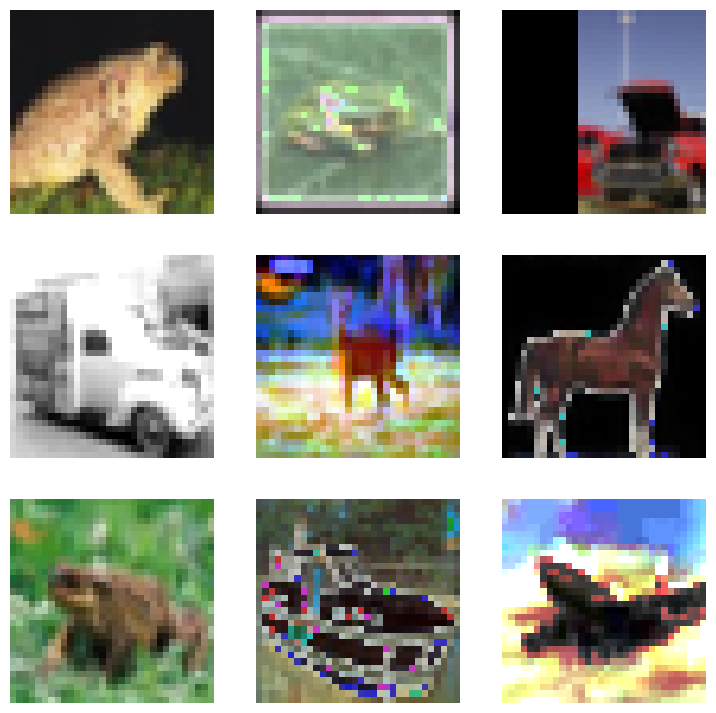

In [62]:
fig, ax = plt.subplots(3, 3, figsize=(9, 9))
for i in range(3):
    for j in range(3):
        train_feature, train_label = next(iter(train_loader))
        ax[i][j].imshow(train_feature[0].permute(1, 2, 0))
        ax[i][j].axis('off')


In [13]:

class MyCNN(nn.Module):
    def __init__(self):
        super(MyCNN, self).__init__()
        self.convSeq1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3),
            nn.MaxPool2d(kernel_size=2),  # 15
            # nn.BatchNorm2d(),
            nn.ReLU(),
        )
        self.convSeq2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=256, kernel_size=3),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(),
        )
        self.flatten = nn.Flatten()
        self.linear1 = nn.Sequential(
            nn.Linear(in_features=256*6*6, out_features=1024),
            nn.ReLU(),
            nn.Linear(in_features=1024, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=10),
        )


    def forward(self, x):
        x = self.convSeq1(x)
        x = self.convSeq2(x)
        x = self.flatten(x)
        x = self.linear1(x)
        # out = self.softmax1(x)
        return x

module = MyCNN().to(device)
print(module(train_feature).shape)
print(module)

torch.Size([64, 10])
MyCNN(
  (convSeq1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
  )
  (convSeq2): Sequential(
    (0): Conv2d(64, 256, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Sequential(
    (0): Linear(in_features=9216, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=10, bias=True)
  )
)


In [14]:
def conv3x3(in_channels, out_channels, stride=1):
    return torch.nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)

class BasicBlock(torch.nn.Module):
    expansion = 1
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = torch.nn.BatchNorm2d(out_channels)
        self.relu = torch.nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = torch.nn.BatchNorm2d(out_channels)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample :
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=1000):
        self.inplanes = 64
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,bias=False)
        self.bn1 = nn.BatchNorm2d(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

module = ResNet(BasicBlock, [2, 2, 2, 2], len(train_dataset.classes)).to(device)

print(module(train_feature).shape)
print(module)

torch.Size([64, 10])
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): 

In [32]:
module.train()
learning_rate = 1e-3
epochs = 40
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(module.parameters(), lr=learning_rate)
size = len(train_loader.dataset)
for i in range(1, epochs+1):
    print(f"Epoch {i + 1}\n----------------------------")
    for batch, (X, y) in enumerate(train_loader):
        X, y = X.to(device), y.to(device)
        pred = module(X)
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f} [{current:>5d}/{size:>5d}]")

Epoch 2
----------------------------
loss: 0.342812 [    0/50000]
loss: 0.282427 [ 6400/50000]
loss: 0.195673 [12800/50000]
loss: 0.184611 [19200/50000]
loss: 0.126864 [25600/50000]
loss: 0.220423 [32000/50000]
loss: 0.257761 [38400/50000]
loss: 0.172456 [44800/50000]
Epoch 3
----------------------------
loss: 0.167210 [    0/50000]
loss: 0.228422 [ 6400/50000]
loss: 0.180249 [12800/50000]
loss: 0.300942 [19200/50000]
loss: 0.172715 [25600/50000]
loss: 0.111725 [32000/50000]
loss: 0.321554 [38400/50000]
loss: 0.151882 [44800/50000]
Epoch 4
----------------------------
loss: 0.156937 [    0/50000]
loss: 0.299917 [ 6400/50000]
loss: 0.330498 [12800/50000]
loss: 0.289973 [19200/50000]
loss: 0.301213 [25600/50000]
loss: 0.201489 [32000/50000]
loss: 0.240307 [38400/50000]
loss: 0.356224 [44800/50000]
Epoch 5
----------------------------
loss: 0.317982 [    0/50000]
loss: 0.248304 [ 6400/50000]
loss: 0.142586 [12800/50000]
loss: 0.251180 [19200/50000]
loss: 0.415597 [25600/50000]
loss: 0.139

In [17]:
loss_fn = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(module.parameters(), lr=learning_rate, momentum=0.9)

In [33]:
test_loss, correct = 0, 0
with torch.no_grad():
    for X, y in test_loader:
        pred = module(X)
        test_loss += loss_fn(pred, y).item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()

print(f"Test Error:\n Accuracy : {(100 * correct / ):>0.1f}%")
print(test_loss / len(test_loader))

Test Error:
 Accuracy : 16.2%
0.7506750377879781


In [18]:
torch.save(module.state_dict(), 'resnetmodule50.kpl')

In [31]:
module = ResNet(BasicBlock, [2, 2, 2, 2], len(train_dataset.classes)).to(device)

dic = torch.load('resnetmodule50.kpl', map_location=torch.device('cpu'))
module.load_state_dict(dic)

<All keys matched successfully>